# Modelo de Predição de Empregabilidade para Universitários 
Davi Santos Rodrigues - 2022043752

1. Introdução:  
    Contexto  
        O presente projeto tem como objetivo analisar os fatores que influenciam a empregabilidade de estudantes universitários, buscando identificar quais características acadêmicas e pessoais aumentam as chances de um aluno ser contratado após a graduação. A análise será conduzida a partir de um conjunto de dados que relaciona o desempenho acadêmico, habilidades interpessoais e experiências práticas com o status de colocação profissional dos alunos.
		
        O tema é relevante no contexto atual, em que a inserção no mercado de trabalho depende não apenas de bom desempenho acadêmico, mas também de competências socioemocionais e experiências complementares.
2. Descrição do Conjunto de Dados:  
    O conjunto de dados utilizado, intitulado College Placement Dataset, contém informações sobre 10.000 estudantes provenientes de diversas instituições. Ele inclui variáveis que representam tanto o desempenho acadêmico quanto as características pessoais dos alunos.


    ![DADOS](Capturadetela.png)

3. Perguntas de pesquisa:
    O projeto foi guiado pela série de perguntas:  
    - Fator Acadêmico: Existe uma diferença significativa no desempenho acadêmico (CGPA) entre alunos empregados e não empregados?  
    - Fator Prático: A quantidade de projetos realizados influencia a colocação no mercado?  
    - O Mito do Estágio: A experiência de estágio é determinante para a contratação?  
    - Predição: É possível construir um modelo de Machine Learning capaz de prever se um aluno será empregado com base em suas características?

4. Metodologia:  
    A analise segue o fluxo da Ciência de Dados dado em sala: Limpeza dos dados, Análise Exploratória, Inferência Estatística, Modelagem e Verificação. O conjunto de dados possui 10 mil registros e é muito bem preenchido. Fiz uma análise da média de cada parâmetro agrupado com a sua colocação e mais para frente no notebook fiz uma análise de correlação entre os fatores. Usei análise de boxplot para responder a primeira pergunta; diferença de médias com bootstrap IC de 95% para responder a segunda; Teste A/B com permutação para responder a terceira; o modelo de predição por regressão logística para responder a quarta.

## 5. Desenvolvimento:


In [1]:
!pip install pandas numpy matplotlib seaborn scipy scikit-learn --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [4]:
df = pd.read_csv("CollegePlacement.csv")

Análise Exploratória:

Os dados são provenientes do site: https://www.kaggle.com/datasets/. Por isso, creio que eles já passaram por uma limpeza e padronização prévia. Abaixo visualizo a natureza dos dados e depois analiso a média de cada grupo, de acordo com a colocação.

In [5]:
colunas_numericas = df.select_dtypes(include=[np.number]).columns
estatisticas = {}
for col in colunas_numericas:
    series = df[col]
    estatisticas[col] = {
        'Média': series.mean(),
        'Mediana': series.median(),
        'Moda': series.mode()[0], 
        'Mínimo': series.min(),
        'Máximo': series.max(),
        'Q1 (25%)': series.quantile(0.25),
        'Q3 (75%)': series.quantile(0.75),
        'Desvio Padrão': series.std(),
        'Variância': series.var()
    }

df_stats = pd.DataFrame(estatisticas).T
display(df_stats.round(2))

,Média,Mediana,Moda,Mínimo,Máximo,Q1 (25%),Q3 (75%),Desvio Padrão,Variância
IQ,99.47,99.00,99.00,41.00,158.00,89.00,110.00,15.05,226.60
Prev_Sem_Result,7.54,7.56,5.93,5.00,10.00,6.29,8.79,1.45,2.10
CGPA,7.53,7.55,9.41,4.54,10.46,6.29,8.77,1.47,2.16
Academic_Performance,5.55,6.00,10.00,1.00,10.00,3.00,8.00,2.87,8.26
Extra_Curricular_Score,4.97,5.00,3.00,0.00,10.00,2.00,8.00,3.16,9.99
Communication_Skills,5.56,6.00,10.00,1.00,10.00,3.00,8.00,2.90,8.42
Projects_Completed,2.51,3.00,5.00,0.00,5.00,1.00,4.00,1.72,2.94


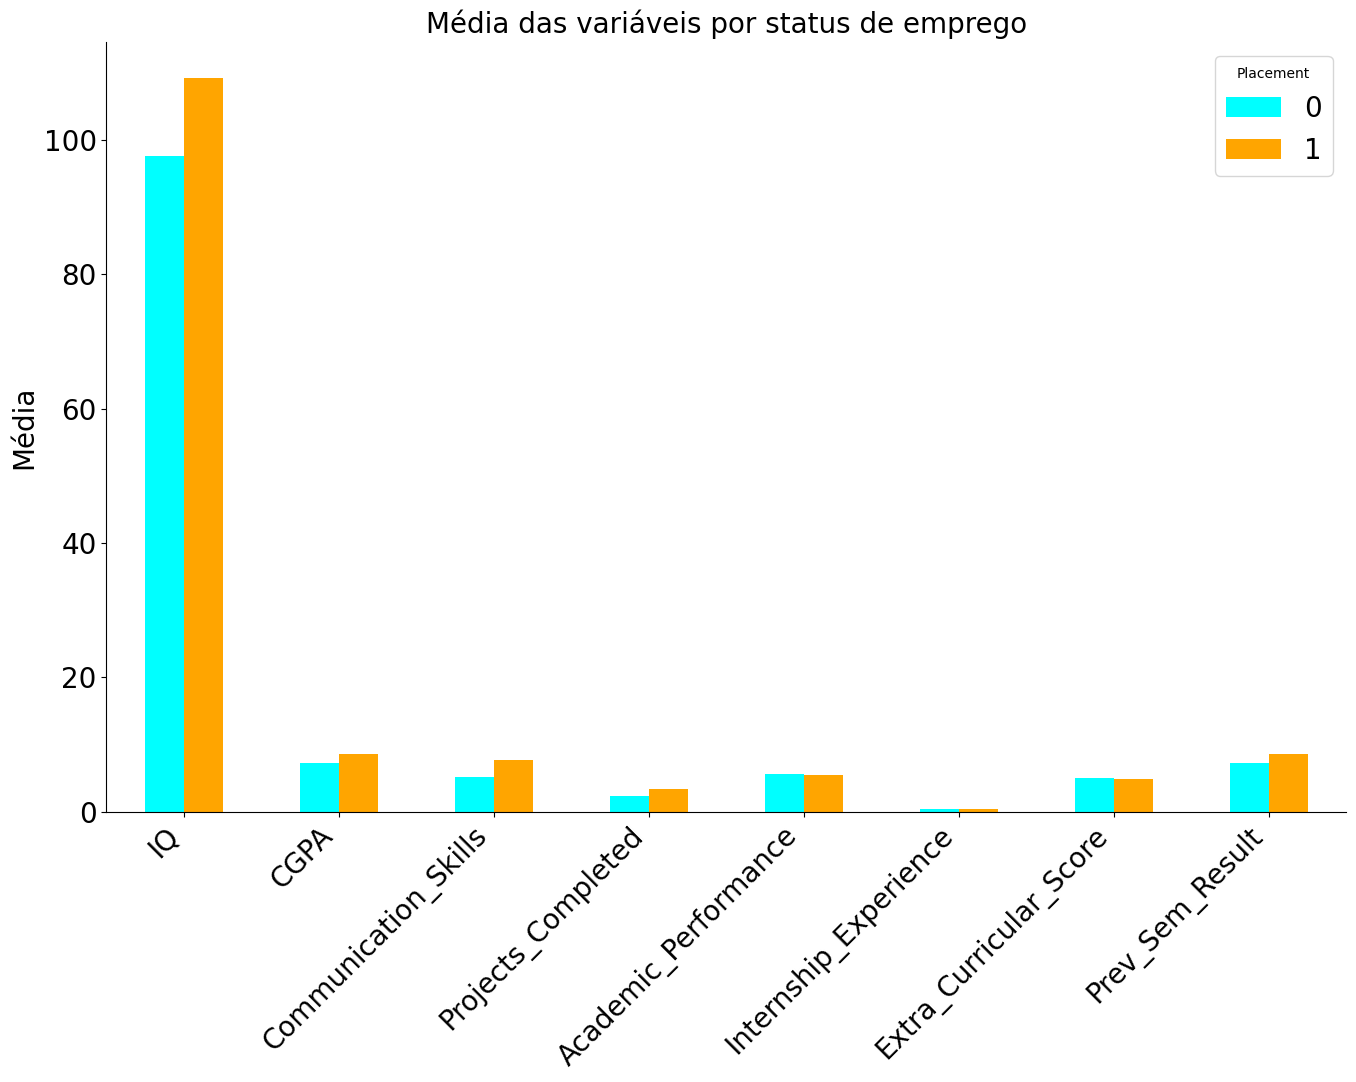

In [6]:
mapa = {'Yes': 1, 'No': 0}
df['Placement'] = df['Placement'].map(mapa)
df['Internship_Experience'] = df['Internship_Experience'].map(mapa)
means = df.groupby("Placement")[["IQ", "CGPA", "Communication_Skills", "Projects_Completed", "Academic_Performance", "Internship_Experience", "Extra_Curricular_Score", "Prev_Sem_Result"]].mean()
aux = means.T.plot(kind="bar", color=['cyan','orange'])
aux.spines['top'].set_visible(False)
aux.spines['right'].set_visible(False)
plt.title("Média das variáveis por status de emprego")
plt.ylabel("Média")
plt.xticks(rotation=45, ha='right')
plt.show()

Notavelmente, as pessoas que estão ocupadas possuem fatores melhores quando comparadas as não ocupadas


Fator Acadêmico: Existe uma diferença significativa no desempenho acadêmico (CGPA) entre alunos empregados e não empregados?  

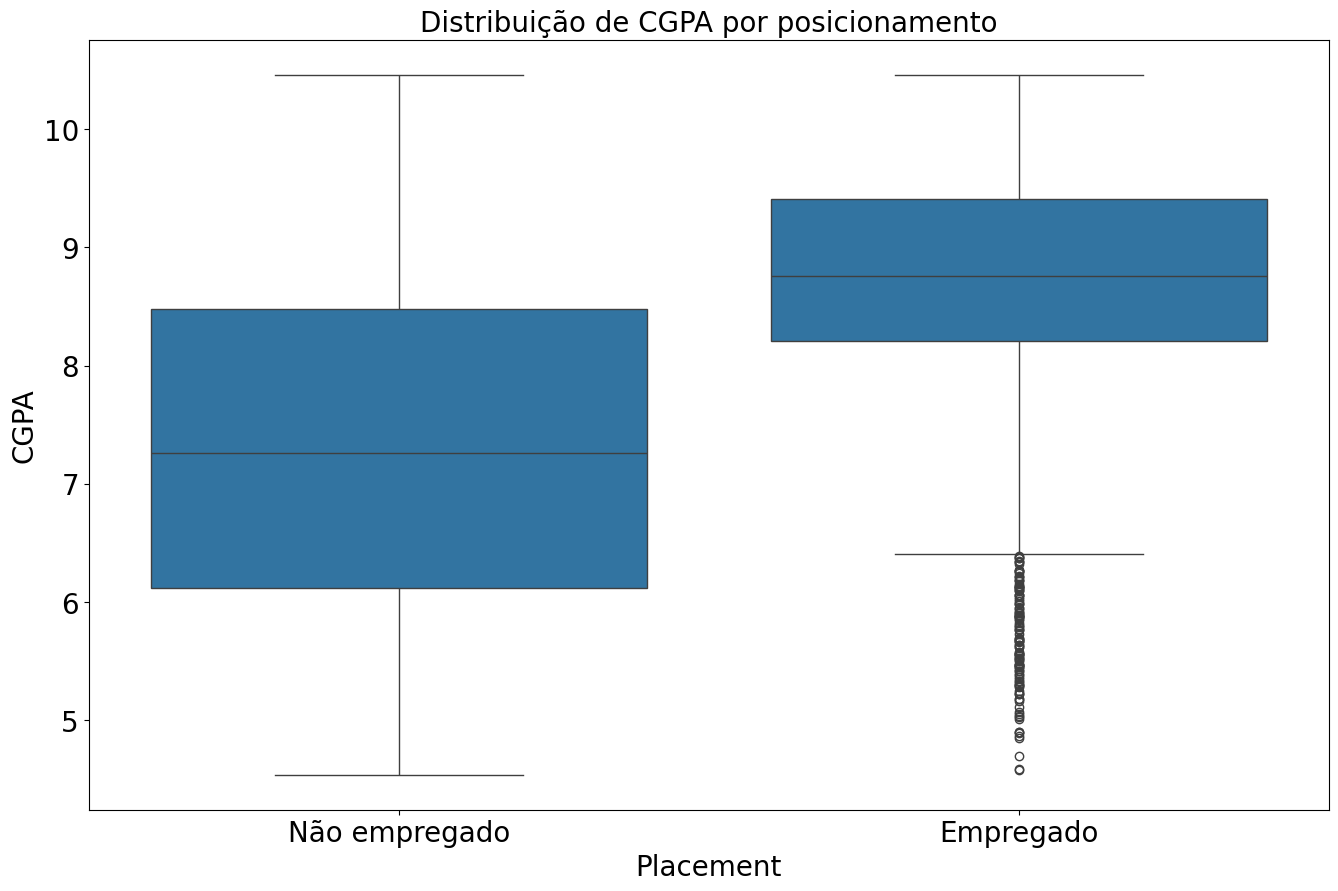

In [7]:
sns.boxplot(x="Placement", y="CGPA", data=df)
plt.title("Distribuição de CGPA por posicionamento")
plt.xticks([0,1], ["Não empregado", "Empregado"])
plt.show()


Geralmente pessoas empregadas terao o CGPA melhor, mas existe um número considerável de outliers, estudantes com o CGPA mais baixo e empregados

## BOOTSRAP PARA DIFERENCA DE MEDIA DE CGPA ENTRE EMPREGADOS E NAO EMPREGADOS

H0 -> Não existe diferenca de CGPA entre empregados e nao empregados, em média  

Ha -> Existe diferenca estatisticamente significativa entre empregados e não empregados, em média

In [8]:

placed = df[df["Placement"] == 1]["CGPA"].dropna()
not_placed = df[df["Placement"] == 0]["CGPA"].dropna()
n1, n2 = len(placed), len(not_placed)
obs_diff = placed.mean() - not_placed.mean()
df.head()

,College_ID,IQ,Prev_Sem_Result,CGPA,Academic_Performance,Internship_Experience,Extra_Curricular_Score,Communication_Skills,Projects_Completed,Placement
0,CLG0030,107,6.61,6.28,8,0,8,8,4,0
1,CLG0061,97,5.52,5.37,8,0,7,8,0,0
2,CLG0036,109,5.36,5.83,9,0,3,1,1,0
3,CLG0055,122,5.47,5.75,6,1,1,6,1,0
4,CLG0004,96,7.91,7.69,7,0,8,10,2,0


In [9]:
def bootstrap_diff_means(data1, data2, n_sub=10000):
    size1, size2 = len(data1), len(data2)
    diffs = np.zeros(n_sub)
    
    for i in range(n_sub):
        sample1 = np.random.choice(data1, size=size1, replace=True)
        sample2 = np.random.choice(data2, size=size2, replace=True)
        diffs[i] = sample1.mean() - sample2.mean()
    
    li, ls = np.percentile(diffs, [2.5, 97.5])
    return diffs, li, ls

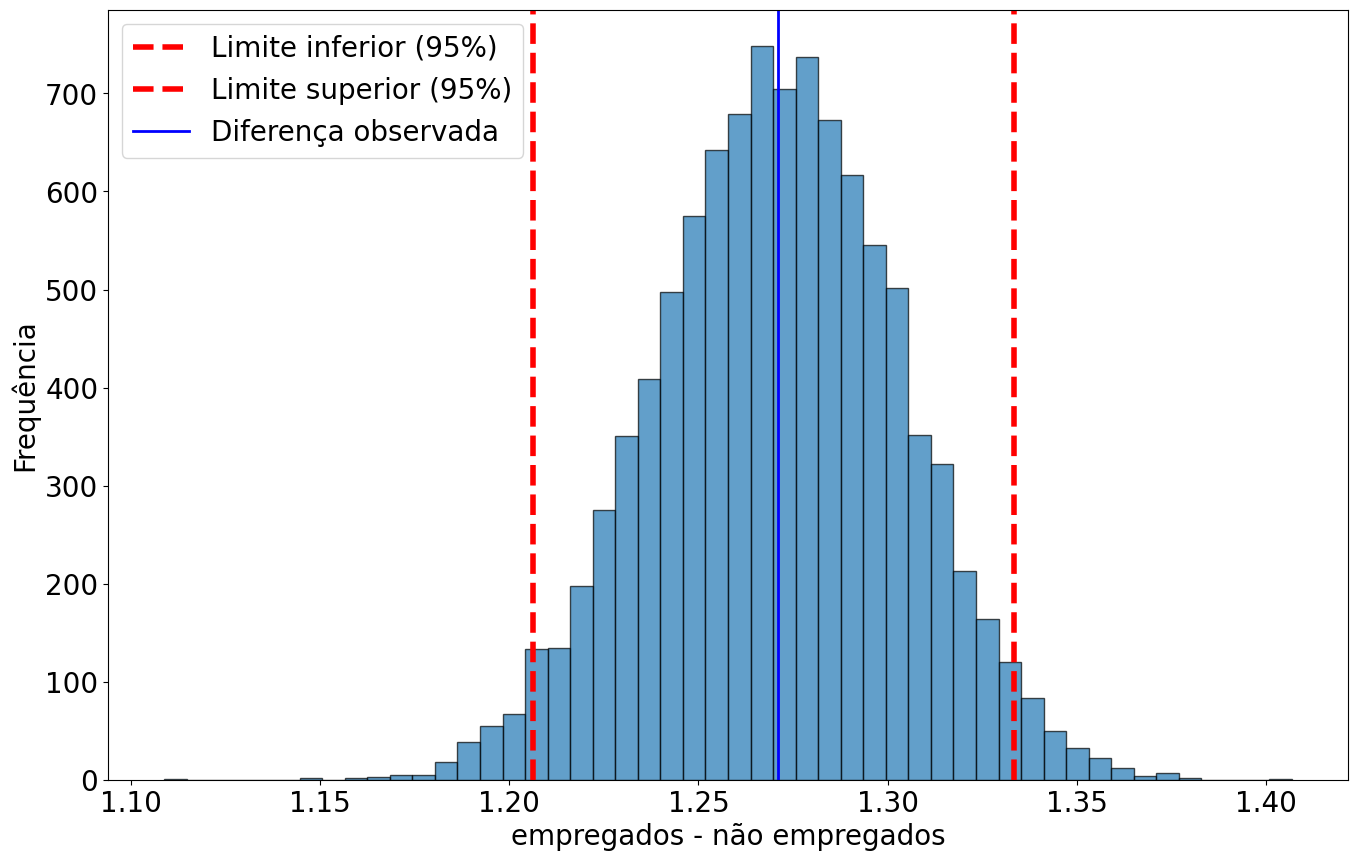

In [10]:
diffs, li, ls = bootstrap_diff_means(placed.values, not_placed.values)
plt.hist(diffs, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(li, color='red', linestyle='--', label='Limite inferior (95%)')
plt.axvline(ls, color='red', linestyle='--', label='Limite superior (95%)')
plt.axvline(obs_diff, color='blue', linestyle='-', linewidth=2, label='Diferença observada')
plt.xlabel("empregados - não empregados")
plt.ylabel("Frequência")
plt.legend()
plt.show()

Dessa forma, podemos ver que a diferenca de média de CGPA de empregados e não empregados é estatisticamente significante

Rejeita a hipotese nula.

# COMPARACAO POR NUMERO DE PROJETOS

H0 -> Não diferenca na media de projetos feitos entre os dois grupos 

HA -> Há diferenca na média de projetos

In [11]:
placed_projects = df[df["Placement"] == 1]["Projects_Completed"].values
not_placed_projects = df[df["Placement"] == 0]["Projects_Completed"].values
obs_diff = placed_projects.mean() - not_placed_projects.mean()

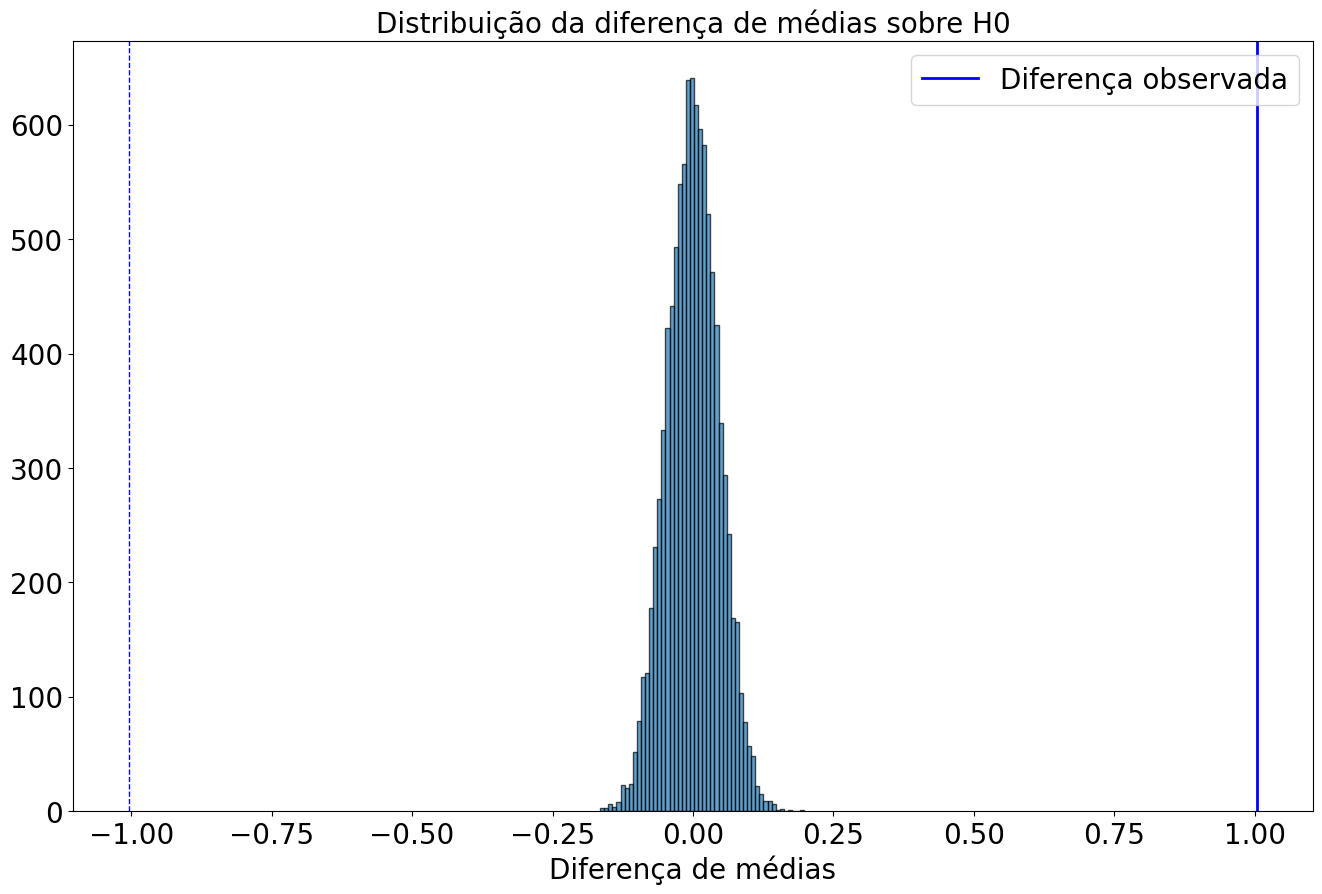

In [12]:
n_perm = 10000
diffs_perm = np.zeros(n_perm)
combined = np.concatenate([placed_projects, not_placed_projects])
for i in range(n_perm):
    np.random.shuffle(combined)
    new_group1 = combined[:len(placed_projects)]
    new_group2 = combined[len(placed_projects):]
    diffs_perm[i] = new_group1.mean() - new_group2.mean()

plt.hist(diffs_perm, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(obs_diff, color='blue', linestyle='-', linewidth=2, label='Diferença observada')
plt.axvline(-obs_diff, color='blue', linestyle='--', linewidth=1)
plt.title("Distribuição da diferença de médias sobre H0")
plt.xlabel("Diferença de médias")
plt.legend()
plt.show()

A hipótese nula não capturou a diferenca das médias amostrais.  
-> Rejeita a hipótese nula.

# CGPA vs ESTAGIO

In [13]:

group_intern = df[df["Internship_Experience"] == 1]["CGPA"].dropna().values
group_no_intern = df[df["Internship_Experience"] == 0]["CGPA"].dropna().values
obs_diff = group_intern.mean() - group_no_intern.mean()

In [14]:
n_perm = 10000
combined = np.concatenate([group_intern, group_no_intern])
diffs_perm = np.zeros(n_perm)

for i in range(n_perm):
    np.random.shuffle(combined)
    new_group1 = combined[:len(group_intern)]
    new_group2 = combined[len(group_intern):]
    diffs_perm[i] = new_group1.mean() - new_group2.mean()

p_value = np.mean(np.abs(diffs_perm) >= np.abs(obs_diff))
print("p-valor:", p_value)

p-valor: 0.2099


In [15]:

diffs, li, ls = bootstrap_diff_means(group_intern, group_no_intern)


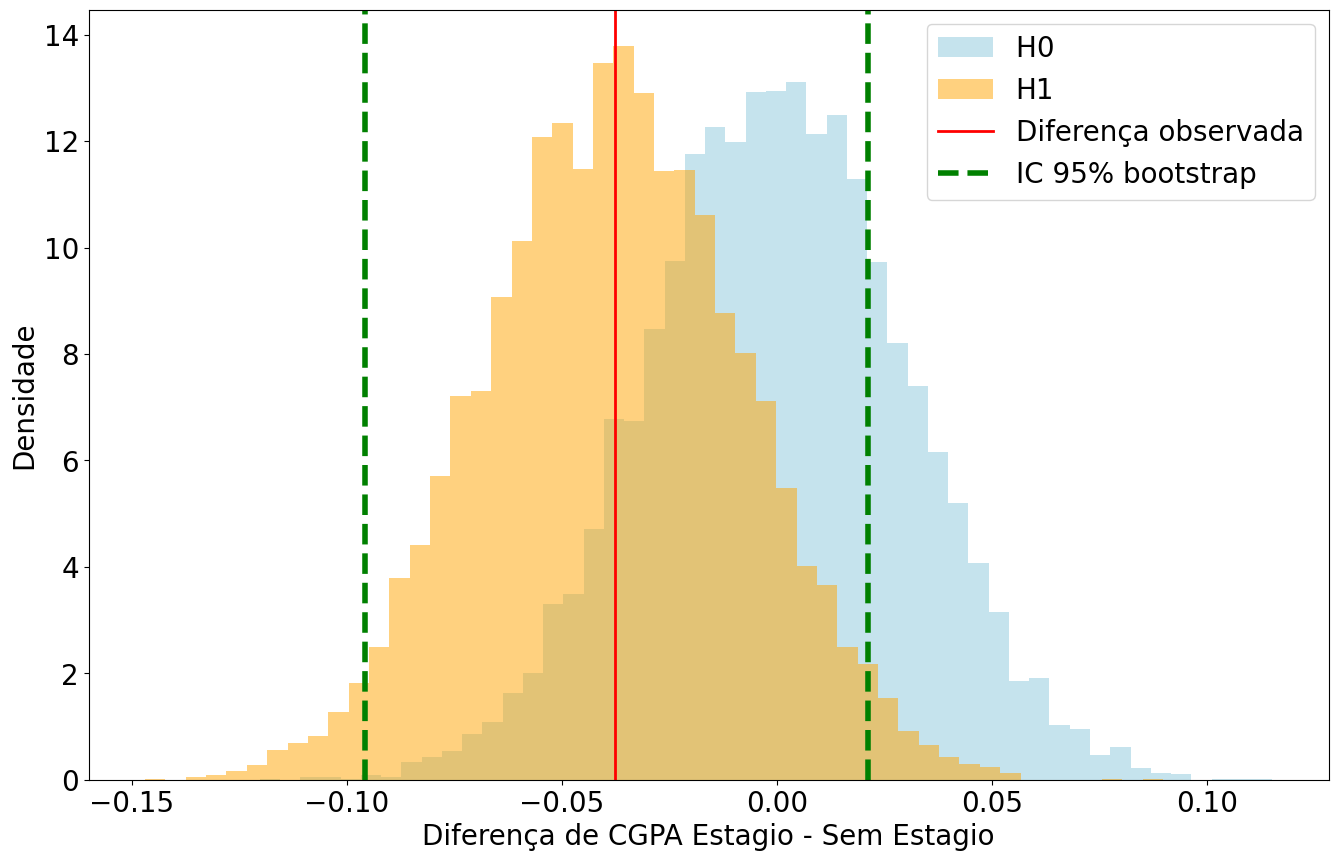

In [16]:
plt.hist(diffs_perm, bins=50, color='lightblue', alpha=0.7, label='H0 ', density=True)
plt.hist(diffs, bins=50, color='orange', alpha=0.5, label='H1', density=True)
plt.axvline(obs_diff, color='red', linestyle='-', linewidth=2, label='Diferença observada')
plt.axvline(li, color='green', linestyle='--', label='IC 95% bootstrap')
plt.axvline(ls, color='green', linestyle='--')
plt.xlabel("Diferença de CGPA Estagio - Sem Estagio")
plt.ylabel("Densidade")
plt.legend()
plt.show()

Não há evidencias suficientes que torne o efeito do estagio sobre o CGPA muito claro

-> Não rejeita a hipótese nula

Existe uma forte associação entre o CGPA e a empregabilidade, o desempenho de um aluno e um grande peso na probabilidade dele ser empregado. As outras análises tendem a mostrar que alunos colocados possuem desempenho melhor em múltiplas dimensões.  
E, apesar do CGPA ser o medidor mais forte, o boxplot e a última analise mostraram que: existe um número considerável de alunos com o CGPA abaixo da média do CGPA de alunos empregados que conseguiram ser colocados; o CGPA não e muito afetado se o aluno fez estágio ou não, portanto não conseguimos dizer se compensa perder desempenho acadêmico para fazer um estagio.

Correlação de variáveis

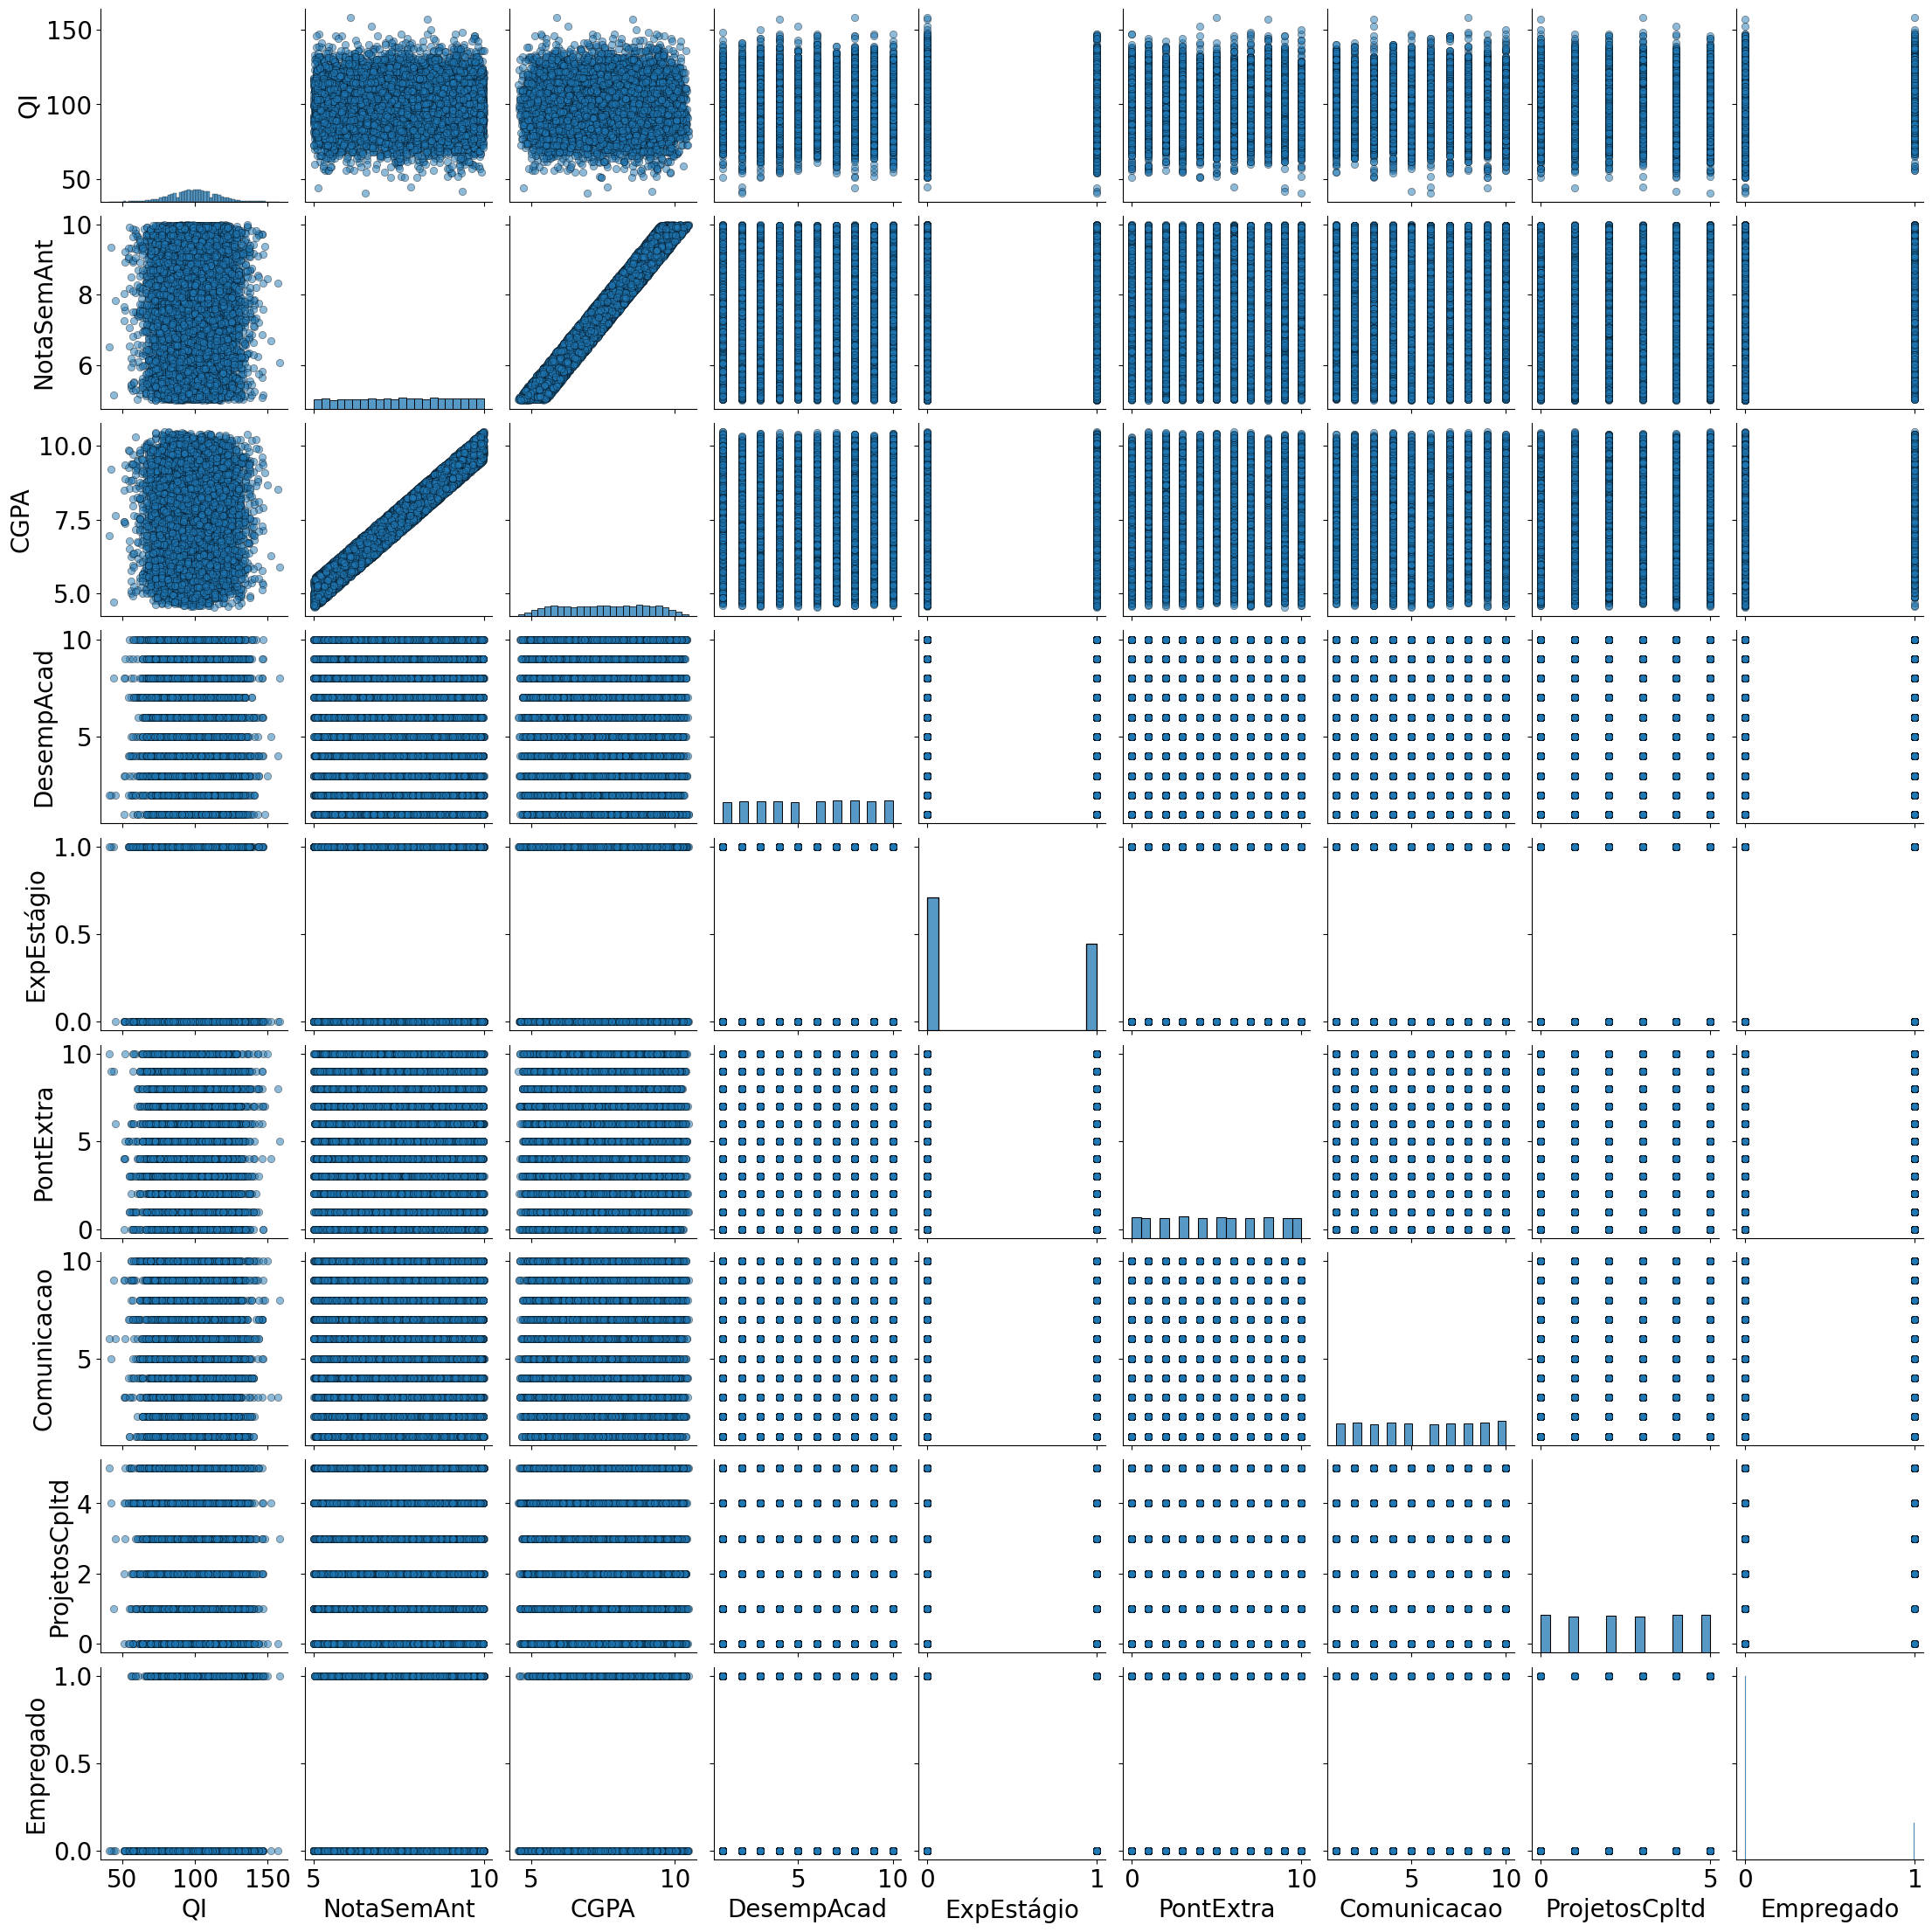

In [17]:
novos_nomes = {
    'College_ID': 'ID Faculdade',
    'IQ': 'QI',
    'Prev_Sem_Result': 'NotaSemAnt',
    'CGPA': 'CGPA',
    'Academic_Performance': 'DesempAcad',
    'Internship_Experience': 'ExpEstágio',
    'Extra_Curricular_Score': 'PontExtra',
    'Communication_Skills': 'Comunicacao',
    'Projects_Completed': 'ProjetosCpltd',
    'Placement': 'Empregado'
}
df_visualizacao = df.rename(columns=novos_nomes)
sns.pairplot(df_visualizacao, diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})

Correlação muito forte entre CGPA e a nota do semestre anterior, vou manter só CGPA por ser mais robusto

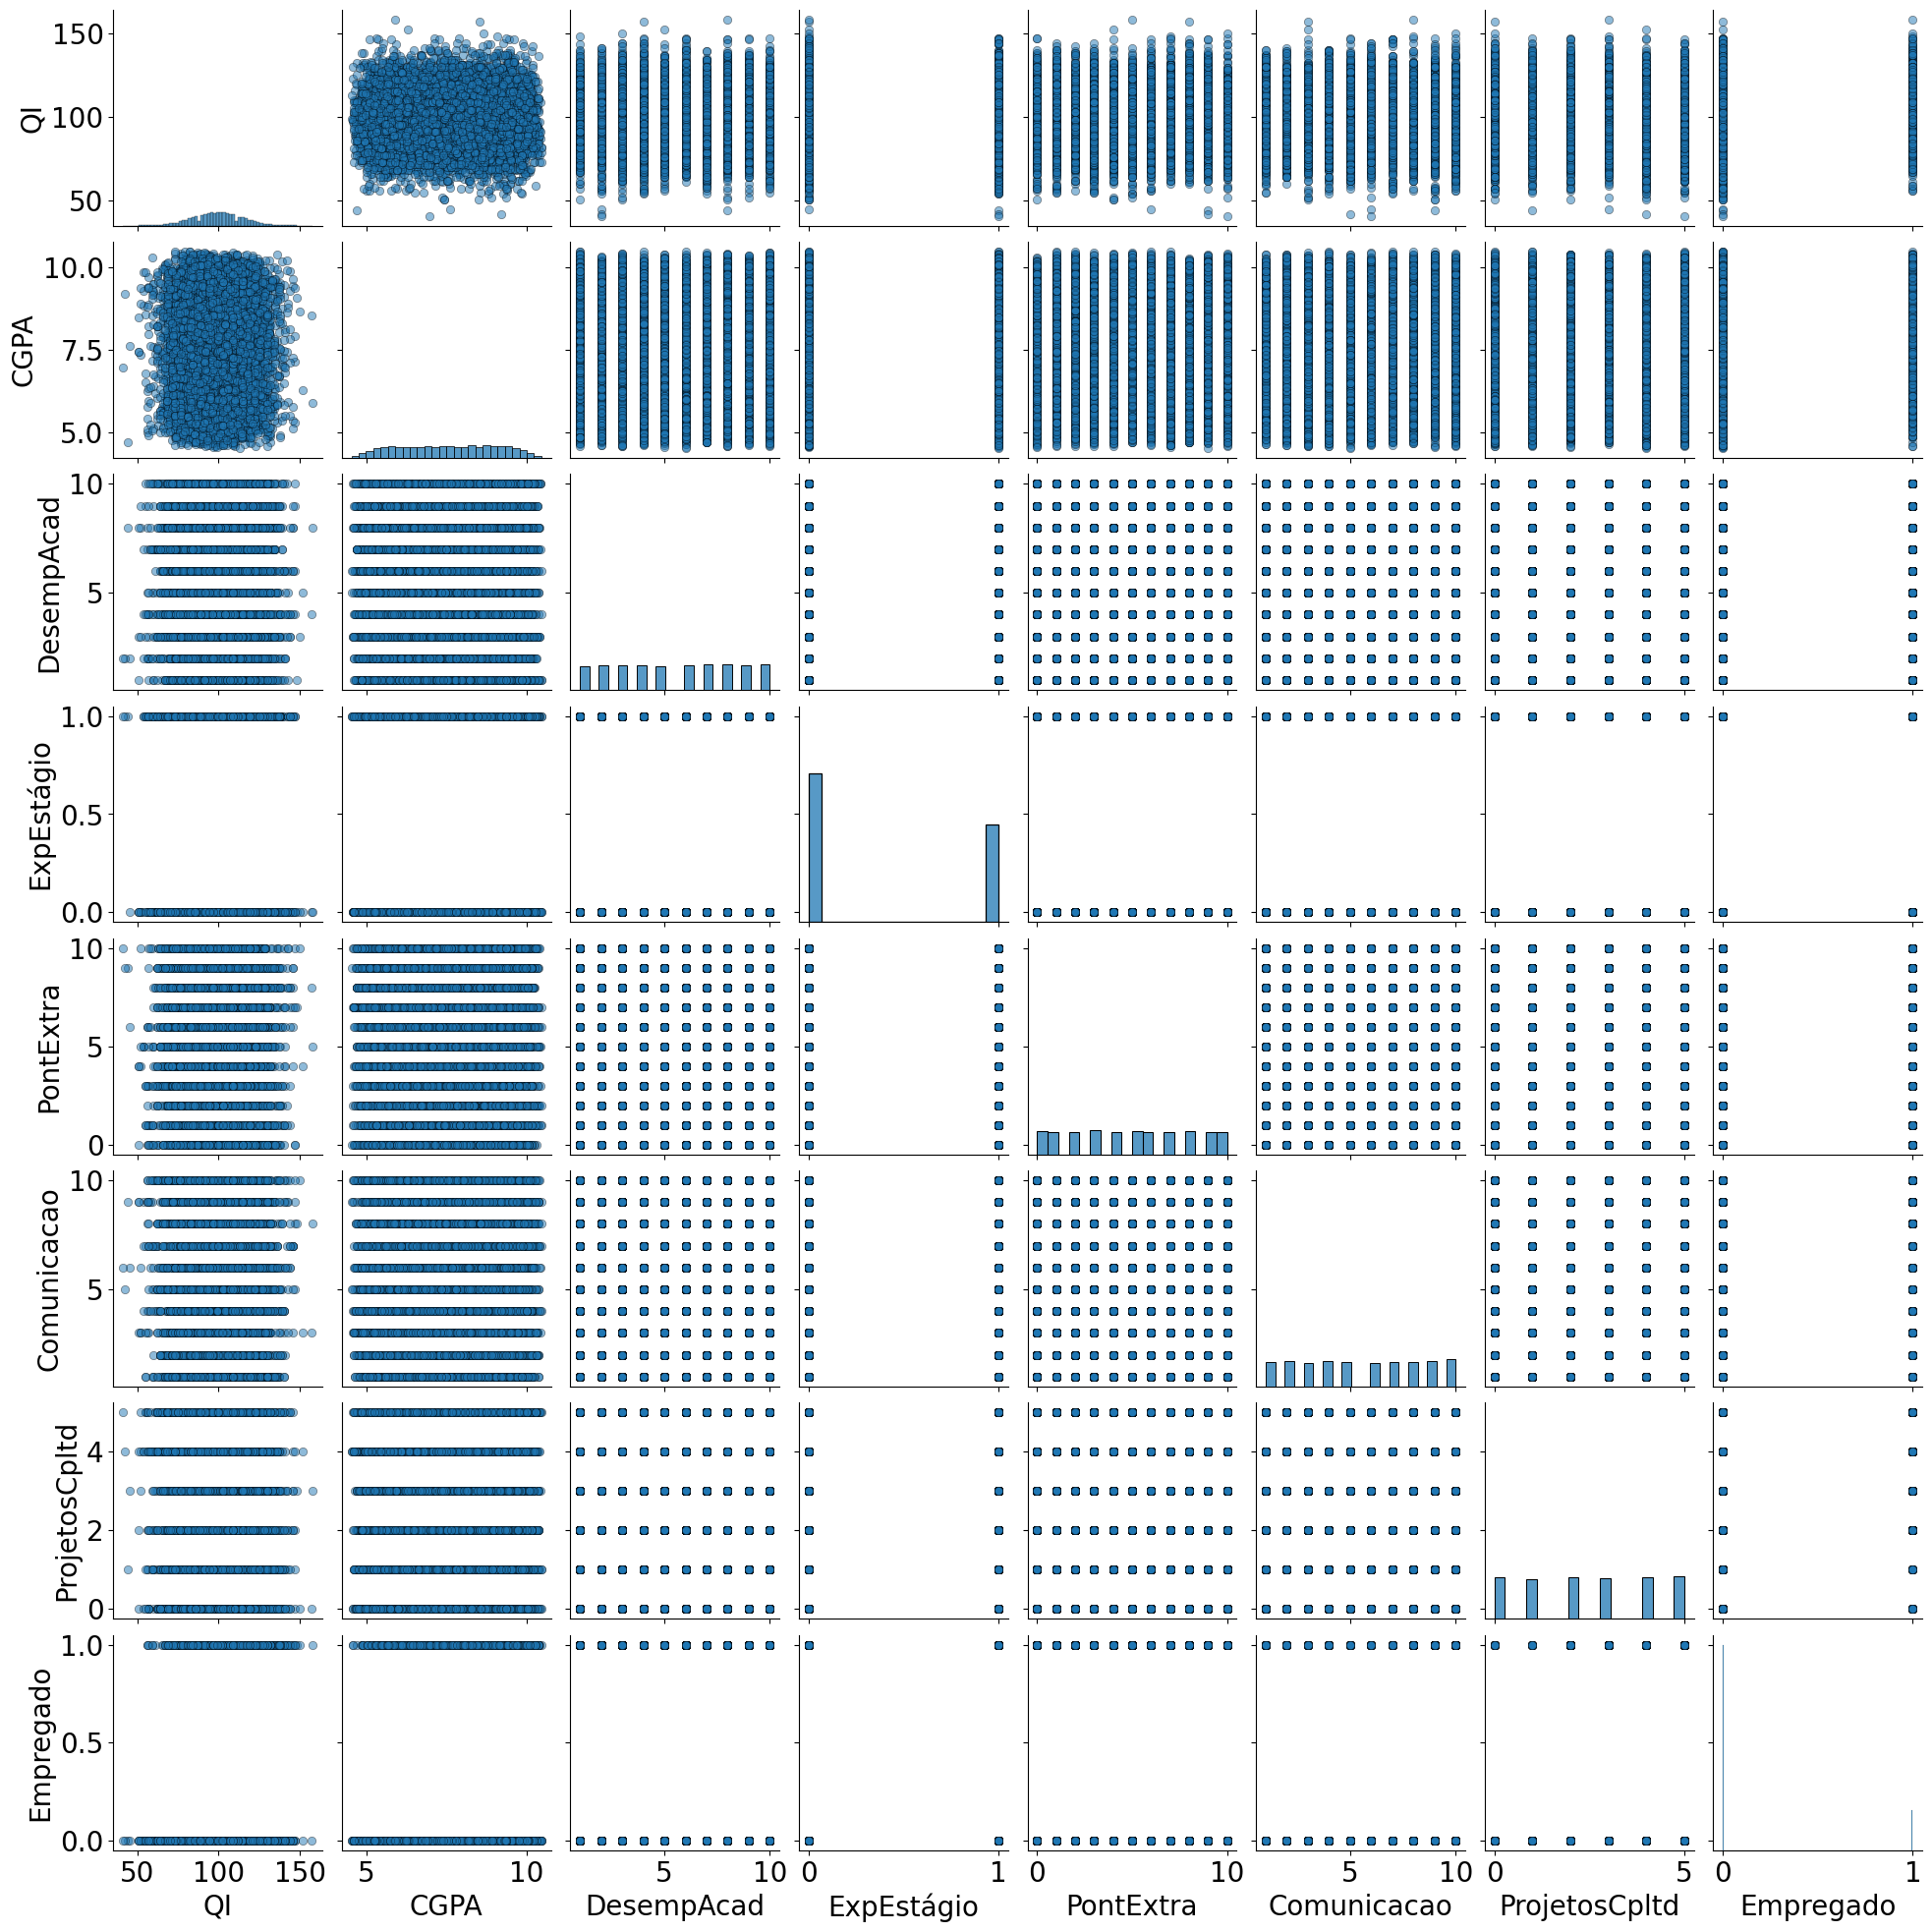

In [18]:
df_limpo = df.drop(columns=['Prev_Sem_Result'])
df_visualizacao = df_limpo.rename(columns=novos_nomes)
sns.pairplot(df_visualizacao, diag_kws={'edgecolor':'k'}, plot_kws={'alpha':0.5, 'edgecolor':'k'})

# Criação do Modelo de Regressão Logística

Objetivo: predizer se um aluno será empregado ou não com base em seus fatores.

In [19]:
#trazendo o sklearn, usado no site do Flávio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [20]:
X = df_limpo.drop(columns=['Placement', 'College_ID']) 
y = df['Placement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler() #z-normaliza
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) #usa media e desvio do treino, Aula 21 Flávio
modelo = LogisticRegression()
modelo.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [21]:
y_pred = modelo.predict(X_test_scaled)

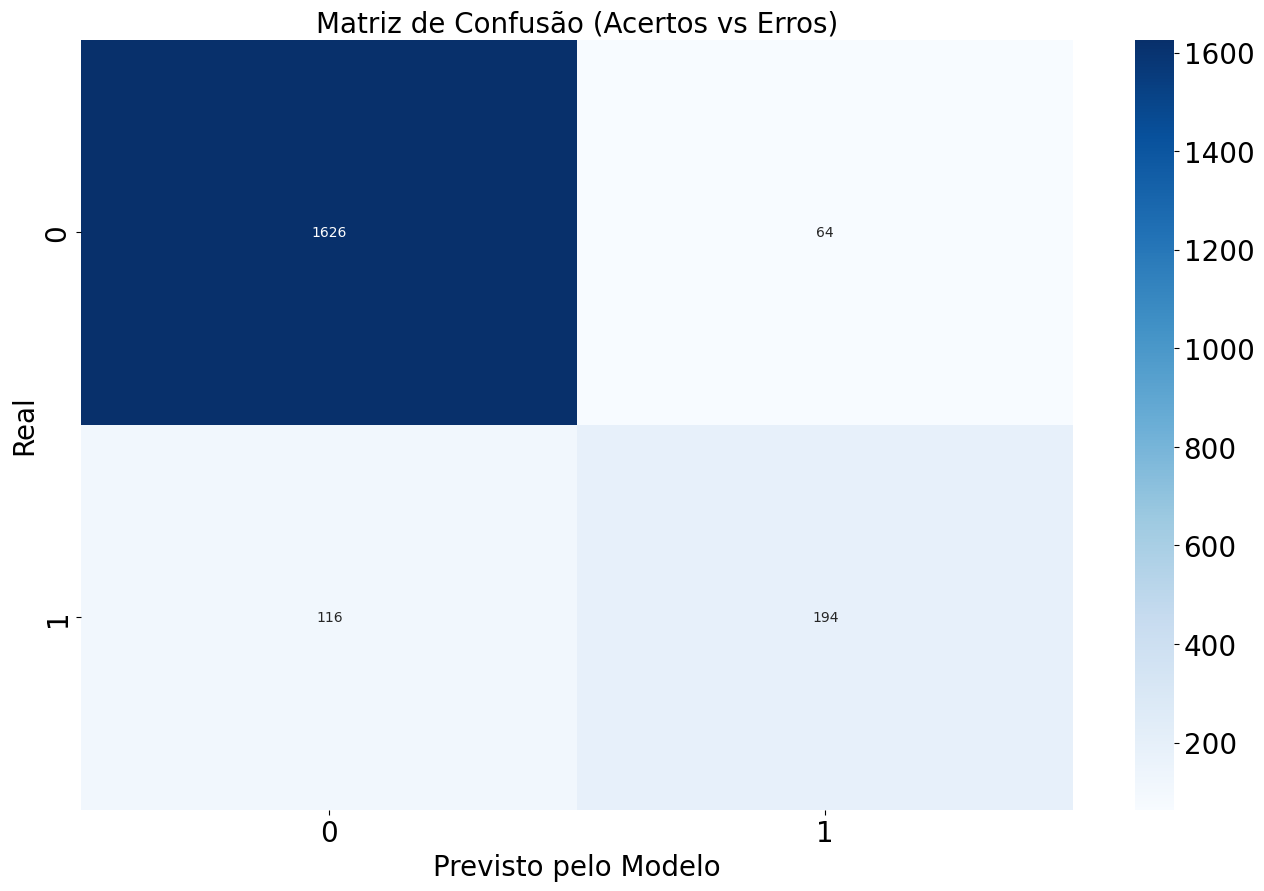

In [22]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão (Acertos vs Erros)")
plt.xlabel("Previsto pelo Modelo")
plt.ylabel("Real")
plt.show()

Desempenho excepcional.

Aluno personalizável para brincar com o modelo.

In [23]:
aluno_ficticio = pd.DataFrame({
    'IQ': [100],                        # QI 
    'CGPA': [6.0],                      # Nota 
    'Academic_Performance': [5],        # DesempAcad 1-10
    'Internship_Experience': [1],       # Estagio 0-1
    'Extra_Curricular_Score': [9],      # PontExtra 1-10
    'Communication_Skills': [9],        # Comunicacao 1-10
    'Projects_Completed': [8]           # Projetos 
})
aluno_scaled = scaler.transform(aluno_ficticio)
predicao = modelo.predict(aluno_scaled)[0]
probabilidade = modelo.predict_proba(aluno_scaled)[0]
status = "contratou!" if predicao == 1 else "nao contratou :("
print("Resultado do Modelo: " + status)


Resultado do Modelo: contratou!


## Análise de Qualidade

Usarei bootstrap para construir IC's sobre os parâmetros do modelo:

In [24]:
nomes_colunas = X.columns
importancia = pd.DataFrame({
    'Variável': nomes_colunas,
    'Peso': modelo.coef_[0] 
})
importancia['Absoluto'] = importancia['Peso'].abs()
importancia = importancia.sort_values(by='Absoluto', ascending=False)

print(importancia)

                 Variável      Peso  Absoluto
5    Communication_Skills  1.877523  1.877523
1                    CGPA  1.815417  1.815417
0                      IQ  1.658921  1.658921
6      Projects_Completed  1.177152  1.177152
4  Extra_Curricular_Score -0.061165  0.061165
2    Academic_Performance -0.044523  0.044523
3   Internship_Experience  0.036314  0.036314


BOOTSTRAP:

Testar confiabilidade dos resultados dos parâmetros e provar que as conclusões não são por acaso.

In [25]:
def bootstrap_regression(X, y, n=10000):
 
    n_samples, n_features = X.shape
    T = np.zeros(shape=(n, n_features))
    
    
    
    for i in range(n):
        
        idx = np.random.choice(n_samples, n_samples)
        Xb = X[idx]
        yb = y[idx]
        
        
        model = LogisticRegression(solver='liblinear', fit_intercept=True)
        model.fit(Xb, yb)
        
        T[i] = model.coef_[0]
        
    return T

In [26]:
y_train_values = y_train.values
T = bootstrap_regression(X_train_scaled, y_train_values)
names = X.columns

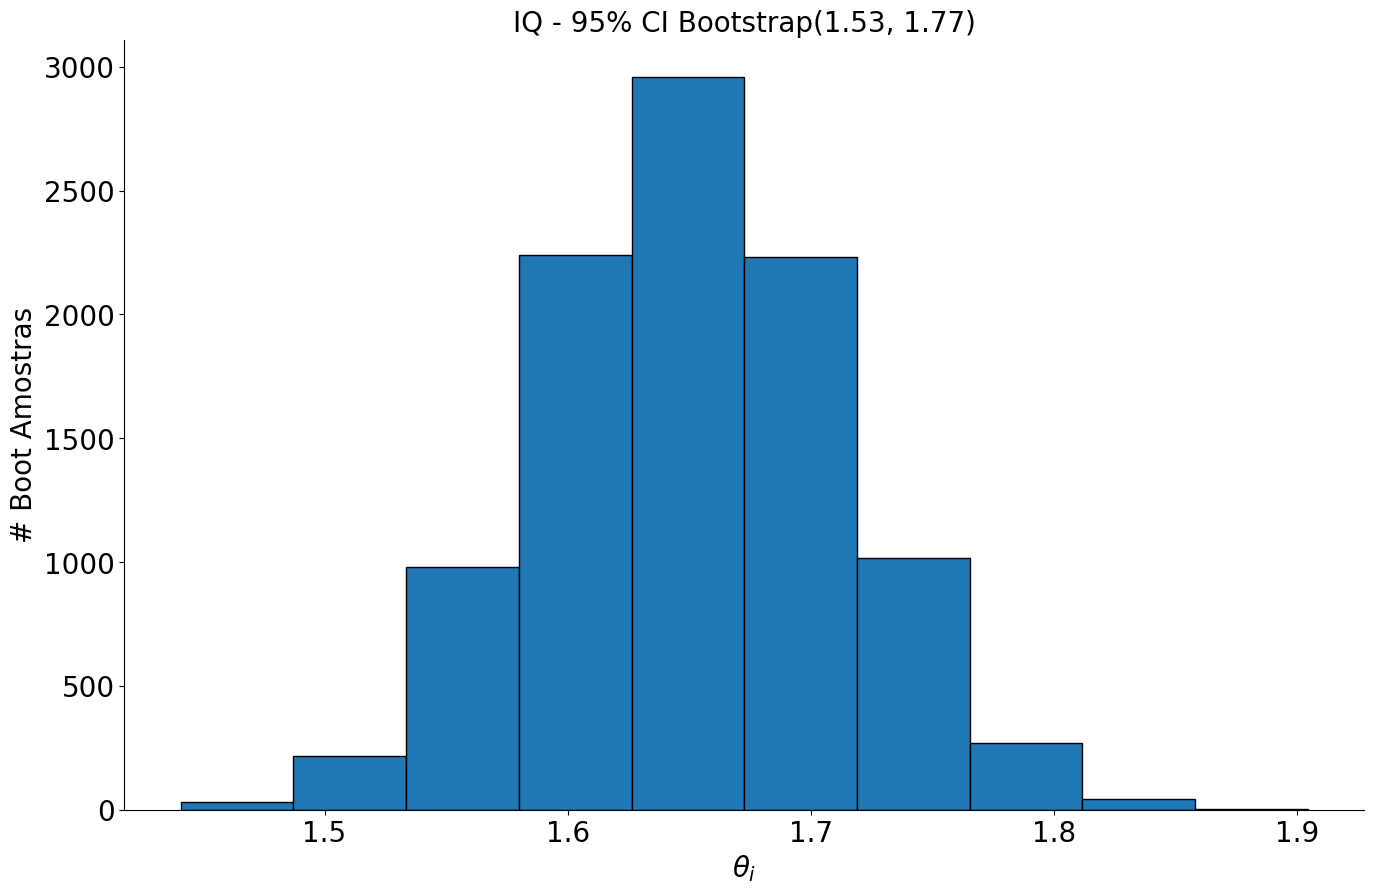

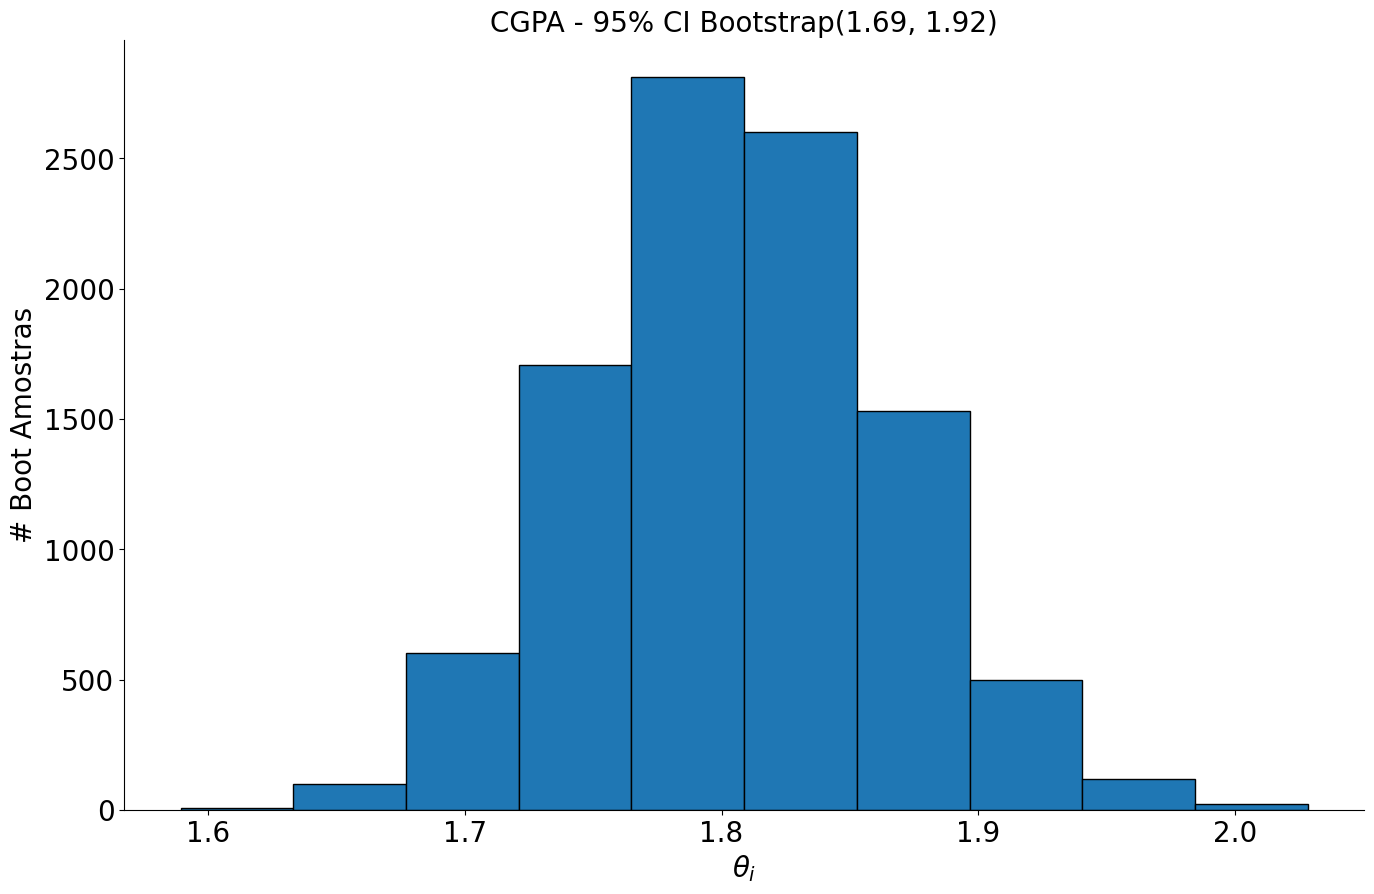

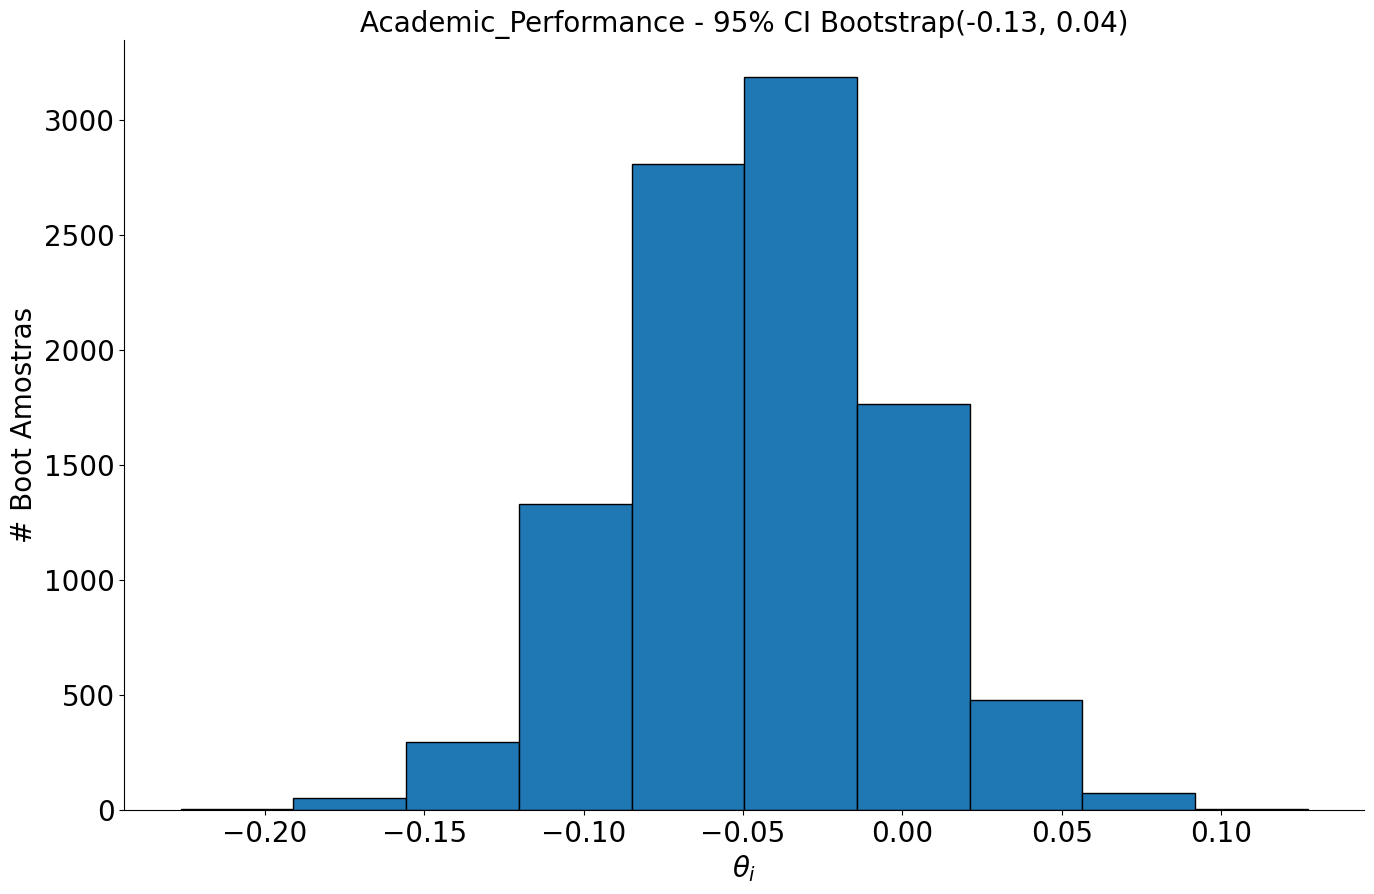

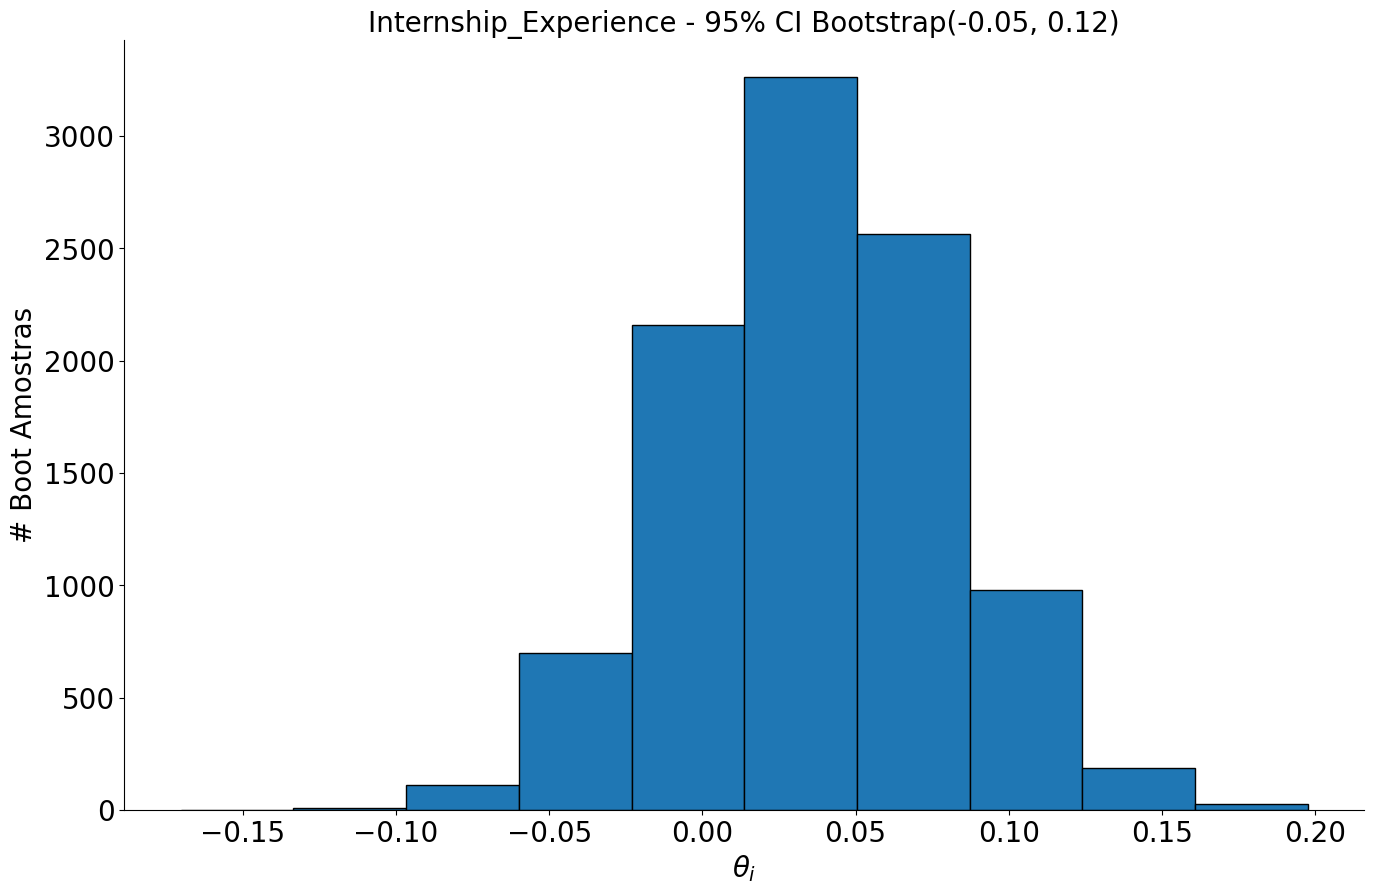

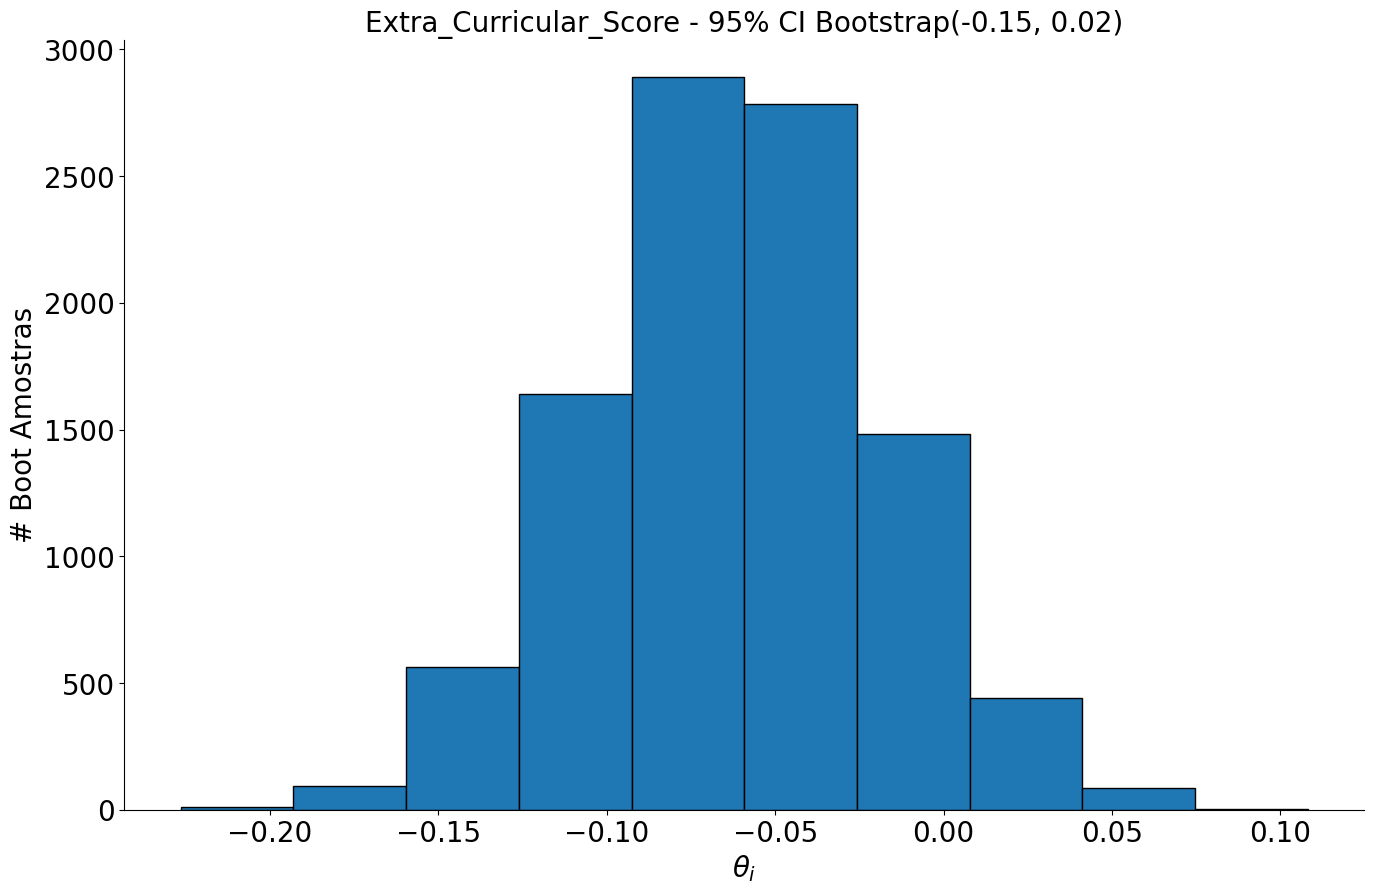

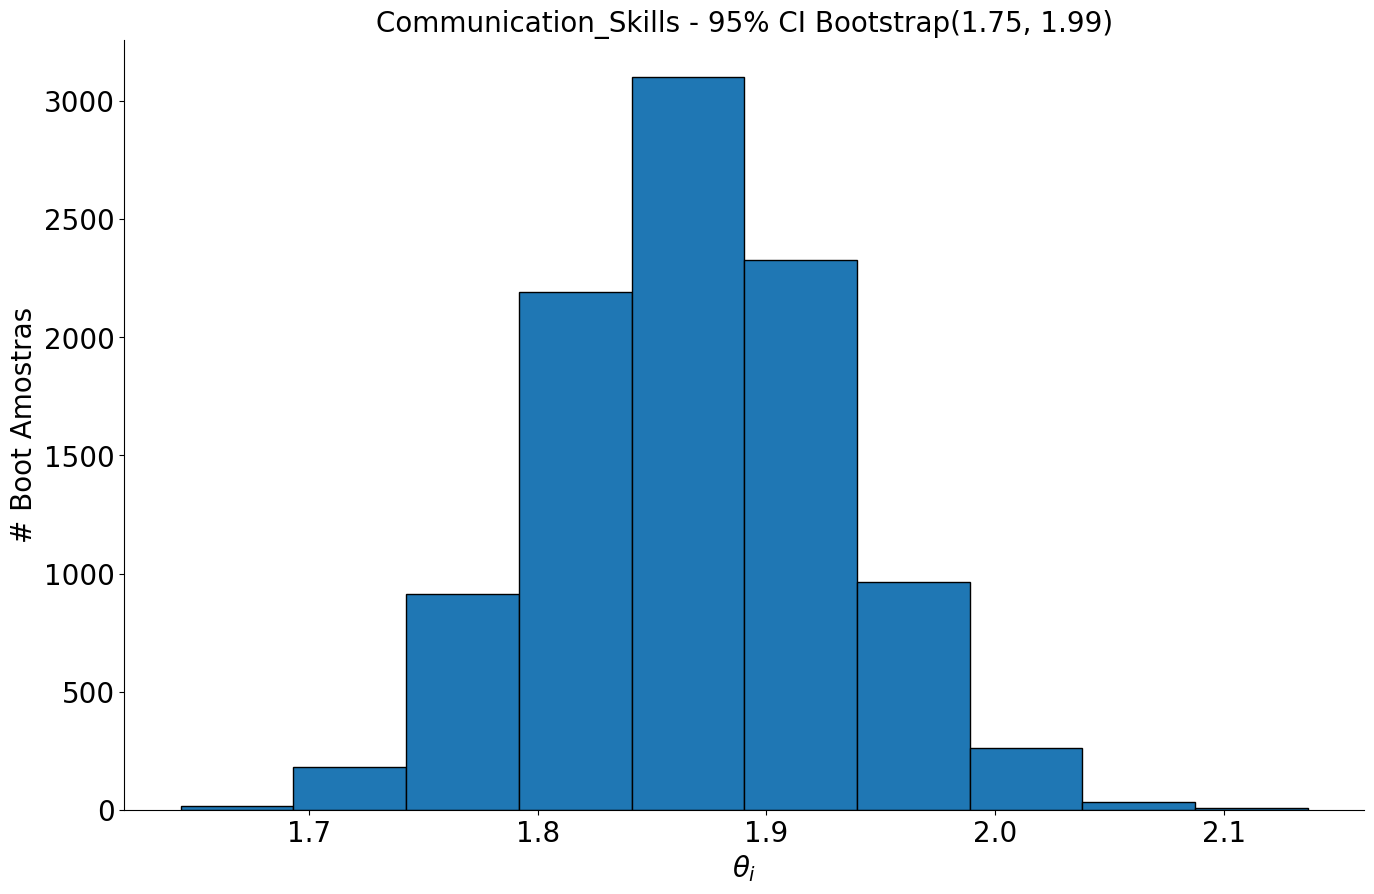

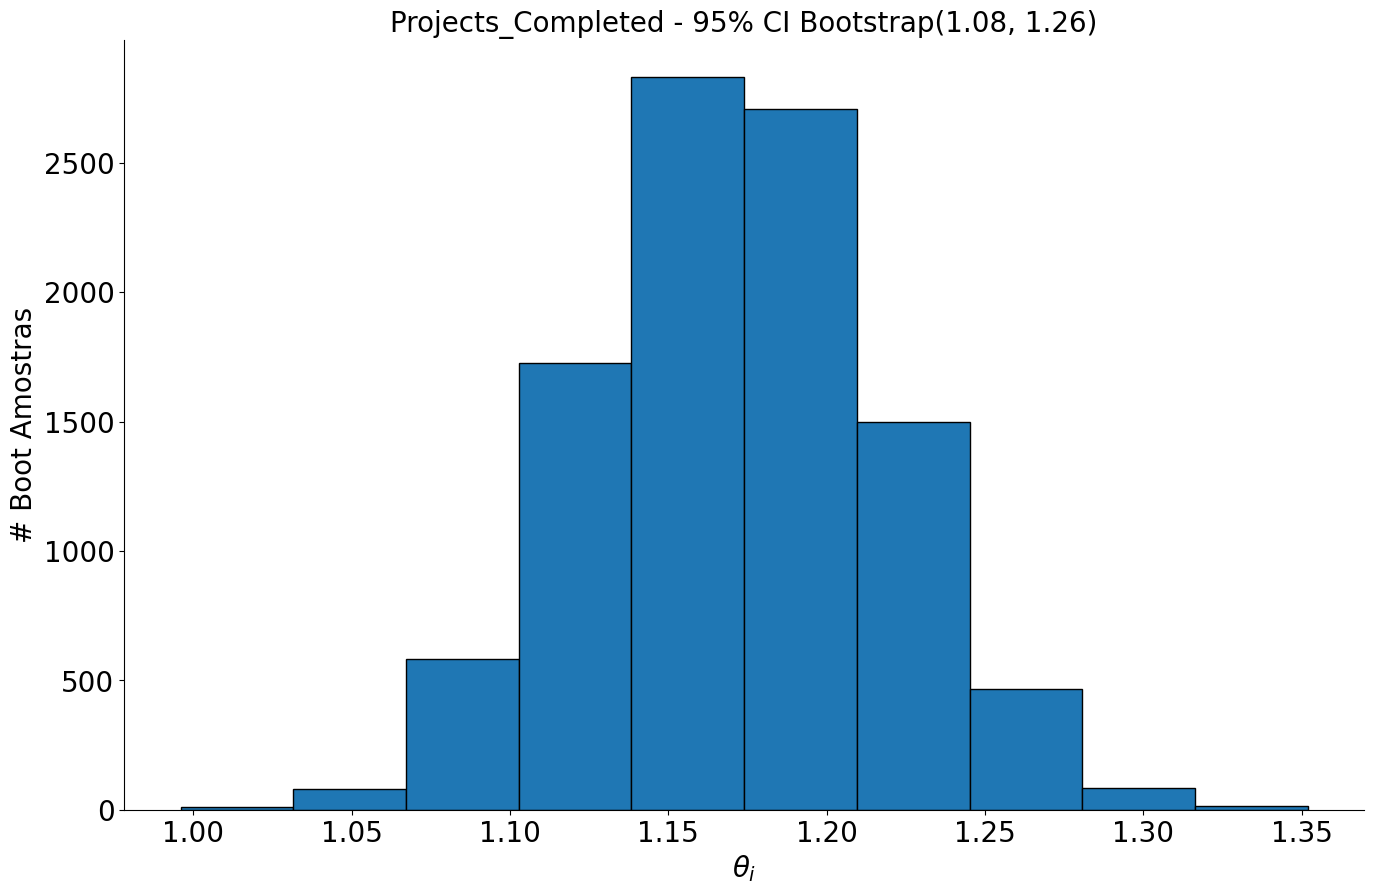

In [27]:
for col in range(T.shape[1]):
    plt.hist(T[:, col], edgecolor='k')
    plt.title('{} - 95% CI Bootstrap({:.2f}, {:.2f})'.format(names[col],
                                                             np.percentile(T[:, col], 2.5),
                                                             np.percentile(T[:, col], 97.5)))
    plt.xlabel(r'$\theta_i$')
    plt.ylabel('# Boot Amostras')
    sns.despine()
    plt.show()

6. Conclusões:

Este estudo buscou identificar os determinantes da empregabilidade em estudantes universitários através de uma abordagem baseada em dados, combinando estatística inferencial e aprendizado de máquina. Com base nas evidências coletadas, apresento as seguintes conclusões:


1. **Fatores Determinantes:** A modelagem preditiva e a análise de importância de variáveis revelaram que quatro pilares sustentam a empregabilidade neste conjunto de dados:  
QI e Habilidades de Comunicação: Foram consistentemente os preditores mais fortes, sugerindo que o mercado valoriza o potencial cognitivo e as soft skills tanto quanto o conhecimento técnico bruto.  
CGPA: A diferença nas médias de CGPA entre alunos contratados e não contratados provou-se estatisticamente significante. Em geral, notas mais altas aumentam drasticamente a chance de contratação.  
Projetos Práticos: A quantidade de projetos realizados mostrou-se um diferencial robusto, indicando que a aplicação prática do conhecimento é valorizada pelos recrutadores.

2. **A Nuance do Desempenho Acadêmico:** Embora o CGPA seja um forte indicador, a análise exploratória identificou a presença de um número considerável de outliers: estudantes com CGPA mais baixo que, ainda assim, conseguiram emprego. Isso sugere que o desempenho acadêmico não é um critério excludente isolado; déficits nas notas podem ser compensados por excelência em outros fatores, como comunicação e portfólio de projetos.

3. **Fatores Irrelevantes ou Inconclusivos:** Contrariando o senso comum, a variável Experiência de Estágio e a métrica genérica de Desempenho Acadêmico apresentaram pesos irrelevantes no modelo final, com intervalos de confiança cruzando o zero.  
Não foram encontradas evidências estatísticas suficientes de que o estágio, isoladamente, exerça um efeito claro sobre o CGPA ou garanta a contratação quando as outras variáveis já são conhecidas. É provável que o impacto do estágio seja indireto ou já esteja capturado pelas variáveis de projetos e habilidades.

Em síntese, a fórmula para empregabilidade, segundo este modelo, não é ser o mais inteligente ou o mais consistente acadêmicamente isoladamente. A fórmula é combinar consistência com inteligência, portfólio e capacidade de execução e, fundamentalmente, saber se comunicar bem. Acredito que é benéfico de se extrapolar para o mundo real, pois muitos alunos perdem a esperança de uma carreira de sucesso por conta de alguns semestres ruins na faculdade e esse modelo mostra que, se há tempo de investir em projetos, e em si mesmo, vale a pena. Um modelo otimista.